<a href="https://colab.research.google.com/github/yanna-torres/CKP9011-ciencia-de-dados/blob/lista-03/lista03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Lista 03 - Análise de Dados
        
> Yanna Torres Gonçalves
>
> Mestrado em Ciências da Computação
>
> Matrícula: 587299

In [2]:
!pip install plotnine statsmodels

In [46]:
import pandas as pd
import numpy as np
import re
import duckdb
import math
import matplotlib.pyplot as plt
from plotnine import *
import scipy
import scipy.stats as stats
import statsmodels
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
%matplotlib inline

## a) Ler o dataset fakeTelegram.BR_2022.csv

Utilizamos o mesmo dataset da lista 01, acessando pelo mesmo link.

[https://github.com/yanna-torres/CKP9011-ciencia-de-dados/blob/lista-01/data/fakeTelegram.BR_2022.csv](https://github.com/yanna-torres/CKP9011-ciencia-de-dados/blob/lista-01/data/fakeTelegram.BR_2022.csv)

In [4]:
data_url = "https://media.githubusercontent.com/media/yanna-torres/CKP9011-ciencia-de-dados/refs/heads/lista-01/data/fakeTelegram.BR_2022.csv"

df = pd.read_csv(data_url)

In [5]:
df.describe()

,dataset_info_id,score_sentiment,score_misinformation,id_message
count,557586.0,444157.000000,167238.000000,5.575860e+05
mean,5.0,0.017330,0.312245,4.450617e+05
std,0.0,0.464165,0.293699,4.860211e+05
min,5.0,-1.000000,0.000003,2.000000e+00
25%,5.0,-0.177900,0.078454,2.127500e+04
50%,5.0,0.000000,0.197577,1.210935e+05
75%,5.0,0.318200,0.490351,9.726045e+05
max,5.0,0.999200,1.000000,1.516436e+06


## b) Remova os trava-zaps

Utilizamos a mesma função da lista 01 criada para validar os dados da coluna `trava_zap`. Após atualizar a coluna, criamos um novo dataframe com os dados sem trava-zaps.

In [6]:
def has_trava_zap(message):
  if not isinstance(message, str):
    return False  # Garante que só analisa strings

  # Regra 1: muito longo
  if len(message) > 10000:
    return True

  # Regra 2: caracteres invisíveis
  invisible = ''.join(chr(c) for c in range(0x200B, 0x200F + 1)) + '\uFEFF'
  if sum(message.count(c) for c in invisible) > 100:
    return True

  # Regra 3: emojis repetidos
  emoji_pattern = re.compile("[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF"
                              "\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+", flags=re.UNICODE)
  emojis = emoji_pattern.findall(message)
  if any(len(e) > 20 for e in emojis):
    return True

  # Regra 4: baixa diversidade
  unique = set(message)
  if len(unique) < 10 and len(message) > 500:
    return True

  return False

In [7]:
df['trava_zap'] = df['text_content_anonymous'].apply(has_trava_zap)

In [8]:
df_clean = df[df['trava_zap'] == False]

In [9]:
df_clean.drop(columns=['trava_zap'], inplace=True)

<ipython-input-9-d18d2c2b7bb2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
df_clean.describe()

,dataset_info_id,score_sentiment,score_misinformation,id_message
count,556305.0,442876.000000,166416.000000,5.563050e+05
mean,5.0,0.017676,0.311496,4.448514e+05
std,0.0,0.463547,0.293146,4.859544e+05
min,5.0,-1.000000,0.000003,2.000000e+00
25%,5.0,-0.177900,0.078334,2.125100e+04
50%,5.0,0.000000,0.196892,1.208690e+05
75%,5.0,0.318200,0.488192,9.724220e+05
max,5.0,0.999200,1.000000,1.516436e+06


## c) Remover as linhas repetidas

In [11]:
df_clean = df_clean.drop_duplicates()

In [12]:
df_clean.describe()

,dataset_info_id,score_sentiment,score_misinformation,id_message
count,556305.0,442876.000000,166416.000000,5.563050e+05
mean,5.0,0.017676,0.311496,4.448514e+05
std,0.0,0.463547,0.293146,4.859544e+05
min,5.0,-1.000000,0.000003,2.000000e+00
25%,5.0,-0.177900,0.078334,2.125100e+04
50%,5.0,0.000000,0.196892,1.208690e+05
75%,5.0,0.318200,0.488192,9.724220e+05
max,5.0,0.999200,1.000000,1.516436e+06


## d) Remover textos com menos de 5 palavras

In [13]:
df_clean = df_clean[df_clean['text_content_anonymous'].str.split().str.len() >= 5]

In [14]:
df.describe()

,dataset_info_id,score_sentiment,score_misinformation,id_message
count,557586.0,444157.000000,167238.000000,5.575860e+05
mean,5.0,0.017330,0.312245,4.450617e+05
std,0.0,0.464165,0.293699,4.860211e+05
min,5.0,-1.000000,0.000003,2.000000e+00
25%,5.0,-0.177900,0.078454,2.127500e+04
50%,5.0,0.000000,0.197577,1.210935e+05
75%,5.0,0.318200,0.490351,9.726045e+05
max,5.0,0.999200,1.000000,1.516436e+06


---

Para facilitar a recuperação de dados em alguns casos, vamos utilizar o duckdb também.

In [15]:
conn = duckdb.connect()

conn.execute("CREATE TABLE messages AS SELECT * FROM df_clean")

In [16]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338045 entries, 0 to 557585
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   date_message            338045 non-null  object 
 1   id_member_anonymous     142383 non-null  object 
 2   id_group_anonymous      338045 non-null  object 
 3   media                   126125 non-null  object 
 4   media_type              126125 non-null  object 
 5   media_url               82697 non-null   object 
 6   has_media               338045 non-null  bool   
 7   has_media_url           338045 non-null  bool   
 8   text_content_anonymous  338045 non-null  object 
 9   dataset_info_id         338045 non-null  int64  
 10  date_system             338045 non-null  object 
 11  score_sentiment         337998 non-null  float64
 12  score_misinformation    166402 non-null  float64
 13  id_message              338045 non-null  int64  
 14  message_type            3

In [17]:
numeric_columns = [
    "score_sentiment",
    "score_misinformation"
]

In [18]:
category_columns = [
    "media_type",
    "has_media",
    "message_type",
    "messenger"
]

## e) Para cada atributo numérico apresente

### 1. Medidas de Tendência Central

*   Média Aritmética
*   Mediana
*   Valor máximo e mínimo

In [19]:
score_sentiment_mean = df_clean['score_sentiment'].mean()
score_sentiment_median = df_clean['score_sentiment'].median()
score_sentiment_max = df_clean['score_sentiment'].max()
score_sentiment_min = df_clean['score_sentiment'].min()

score_misinformation_mean = df_clean['score_misinformation'].mean()
score_misinformation_median = df_clean['score_misinformation'].median()
score_misinformation_max = df_clean['score_misinformation'].max()
score_misinformation_min = df_clean['score_misinformation'].min()

In [20]:
numeric_stats_params = {
    'score_sentiment': {
        'mean': df_clean['score_sentiment'].mean(),
        'median': df_clean['score_sentiment'].median(),
        'max': df_clean['score_sentiment'].max(),
        'min': df_clean['score_sentiment'].min()
    },
    'score_misinformation': {
        'mean': df_clean['score_misinformation'].mean(),
        'median': df_clean['score_misinformation'].median(),
        'max': df_clean['score_misinformation'].max(),
        'min': df_clean['score_misinformation'].min()
    }
}

numeric_stats_params_df = pd.DataFrame(numeric_stats_params)
numeric_stats_params_df

,score_sentiment,score_misinformation
mean,0.022497,0.311514
median,0.000000,0.196925
max,0.999200,1.000000
min,-1.000000,0.000003


### 2. Medidas de Variabilidade

*   Desvio em relação à média
*   Variância
*   Desvio Padrão

In [21]:
score_sentiment_mean_deviation = (df_clean['score_sentiment'] - df_clean['score_sentiment'].mean()).abs().mean()
score_sentiment_variance = df_clean['score_sentiment'].var()
score_sentiment_std = df_clean['score_sentiment'].std()

score_misinformation_mean_deviation = (df_clean['score_misinformation'] - df_clean['score_misinformation'].mean()).abs().mean()
score_misinformation_variance = df_clean['score_misinformation'].var()
score_misinformation_std = df_clean['score_misinformation'].std()

In [22]:
numeric_stats_variablity_params = {
    'score_sentiment': {
        'mean_deviation': score_sentiment_mean_deviation,
        'variance': score_sentiment_variance,
        'std': score_sentiment_std
    },
    'score_misinformation': {
        'mean_deviation': score_misinformation_mean_deviation,
        'variance': score_misinformation_variance,
        'std': score_misinformation_std
    }
}

numeric_stats_variablity_params_df = pd.DataFrame(numeric_stats_variablity_params)
numeric_stats_variablity_params_df

,score_sentiment,score_misinformation
mean_deviation,0.425371,0.243704
variance,0.280067,0.085937
std,0.529214,0.293150


### 3. Tabela de Frequência e Histograma

#### Score Sentiment

In [23]:
# 1. Número de classes (k) - Regra de Sturges
n_ss = len(df_clean)
k_ss = math.ceil(1 + 3.3 * math.log10(n_ss))

# 2. Intervalo da variável
min_val_ss = df_clean['score_sentiment'].min()
max_val_ss = df_clean['score_sentiment'].max()

# 3. Amplitude dos intervalos
amplitude_ss = (max_val_ss - min_val_ss) / k_ss

# 4. Criar os intervalos de classe
bins_ss = [min_val_ss + i * amplitude_ss for i in range(k_ss+1)]
labels_ss = [f"[{round(bins_ss[i], 2)}, {round(bins_ss[i+1], 2)})" for i in range(k_ss)]

# 5. Classificar os dados
df_clean['classe_ss'] = pd.cut(df_clean['score_sentiment'], bins=bins_ss, labels=labels_ss, include_lowest=True, right=False)

# 6. Frequências
frequencia_abs_ss = df_clean['classe_ss'].value_counts().reindex(labels_ss, fill_value=0)
frequencia_rel_ss = (frequencia_abs_ss / n_ss).round(4)
frequencia_per_ss = (frequencia_rel_ss * 100).round(2)
frequencia_acum_per_ss = frequencia_per_ss.cumsum()
densidade_ss = (frequencia_rel_ss / amplitude_ss).round(4)
# Calcular pontos médios de cada classe
pontos_medios_ss = [round((bins_ss[i] + bins_ss[i+1]) / 2, 4) for i in range(k_ss)]


# 7. Tabela final
tabela_frequencia_ss = pd.DataFrame({
    'Classe': labels_ss,
    'Frequência Absoluta': frequencia_abs_ss.values,
    'Frequência Relativa': frequencia_rel_ss.values,
    'Frequência Percentual': frequencia_per_ss.values,
    'Frequência Acumulada (%)': frequencia_acum_per_ss.values,
    'Densidade': densidade_ss.values,
    'Ponto Médio': pontos_medios_ss,
})


# 8. Exibir
print("Tabela de Frequência: Score Sentiment")
tabela_frequencia_ss

Tabela de Frequência: Score Sentiment


,Classe,Frequência Absoluta,Frequência Relativa,Frequência Percentual,Frequência Acumulada (%),Densidade,Ponto Médio
0,"[-1.0, -0.9)",12751,0.0377,3.77,3.77,0.3772,-0.9500
1,"[-0.9, -0.8)",12620,0.0373,3.73,7.50,0.3731,-0.8501
2,"[-0.8, -0.7)",13896,0.0411,4.11,11.61,0.4112,-0.7501
3,"[-0.7, -0.6)",14008,0.0414,4.14,15.75,0.4142,-0.6501
4,"[-0.6, -0.5)",14658,0.0434,4.34,20.09,0.4342,-0.5502
5,"[-0.5, -0.4)",15661,0.0463,4.63,24.72,0.4632,-0.4502
6,"[-0.4, -0.3)",10108,0.0299,2.99,27.71,0.2991,-0.3503
7,"[-0.3, -0.2)",14998,0.0444,4.44,32.15,0.4442,-0.2503
8,"[-0.2, -0.1)",14222,0.0421,4.21,36.36,0.4212,-0.1503
9,"[-0.1, -0.0)",4209,0.0125,1.25,37.61,0.1251,-0.0504


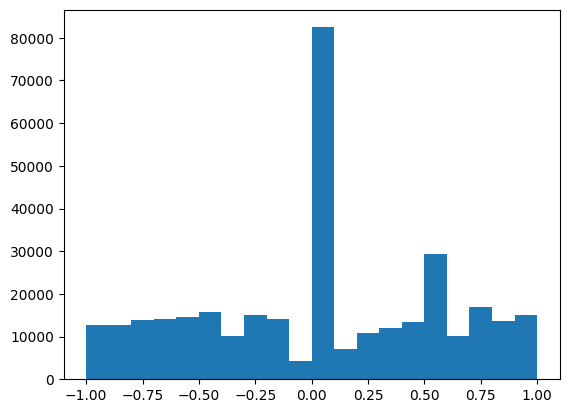

In [24]:
plt.hist(df_clean['score_sentiment'], bins=k_ss)
plt.show()

#### Score Misinformation

In [25]:
# 1. Número de classes (k) - Regra de Sturges
n_sm = len(df_clean)
k_sm = math.ceil(1 + 3.3 * math.log10(n_sm))

# 2. Intervalo da variável
min_val_sm = df_clean['score_misinformation'].min()
max_val_sm = df_clean['score_misinformation'].max()

# 3. Amplitude dos intervalos
amplitude_sm = (max_val_sm - min_val_sm) / k_sm

# 4. Criar os intervalos de classe
bins_sm = [min_val_sm + i * amplitude_sm for i in range(k_sm+1)]
labels_sm = [f"[{round(bins_sm[i], 2)}, {round(bins_sm[i+1], 2)})" for i in range(k_sm)]

# 5. Classificar os dados
df_clean['classe_sm'] = pd.cut(df_clean['score_misinformation'], bins=bins_sm, labels=labels_sm, include_lowest=True, right=False)

# 6. Frequências
frequencia_abs_sm = df_clean['classe_sm'].value_counts().reindex(labels_sm, fill_value=0)
frequencia_rel_sm = (frequencia_abs_sm / n_sm).round(4)
frequencia_per_sm = (frequencia_rel_sm * 100).round(2)
frequencia_acum_per_sm = frequencia_per_sm.cumsum()
densidade_sm = (frequencia_rel_sm / amplitude_sm).round(4)
# Calcular pontos médios de cada classe
pontos_medios_sm = [round((bins_sm[i] + bins_sm[i+1]) / 2, 4) for i in range(k_sm)]


# 7. Tabela final
tabela_frequencia_sm = pd.DataFrame({
    'Classe': labels_sm,
    'Frequência Absoluta': frequencia_abs_sm.values,
    'Frequência Relativa': frequencia_rel_sm.values,
    'Frequência Percentual': frequencia_per_sm.values,
    'Frequência Acumulada (%)': frequencia_acum_per_sm.values,
    'Densidade': densidade_sm.values,
    'Ponto Médio': pontos_medios_sm,
})


# 8. Exibir
print("Tabela de Frequência: Score Misinformation")
tabela_frequencia_sm


Tabela de Frequência: Score Misinformation


,Classe,Frequência Absoluta,Frequência Relativa,Frequência Percentual,Frequência Acumulada (%),Densidade,Ponto Médio
0,"[0.0, 0.05)",27892,0.0825,8.25,8.25,1.650,0.025
1,"[0.05, 0.1)",23074,0.0683,6.83,15.08,1.366,0.075
2,"[0.1, 0.15)",18951,0.0561,5.61,20.69,1.122,0.125
3,"[0.15, 0.2)",14012,0.0415,4.15,24.84,0.830,0.175
4,"[0.2, 0.25)",11003,0.0325,3.25,28.09,0.650,0.225
5,"[0.25, 0.3)",8088,0.0239,2.39,30.48,0.478,0.275
6,"[0.3, 0.35)",6850,0.0203,2.03,32.51,0.406,0.325
7,"[0.35, 0.4)",5942,0.0176,1.76,34.27,0.352,0.375
8,"[0.4, 0.45)",5376,0.0159,1.59,35.86,0.318,0.425
9,"[0.45, 0.5)",4663,0.0138,1.38,37.24,0.276,0.475


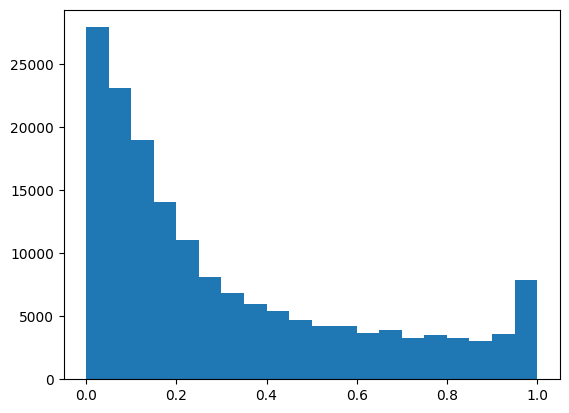

In [26]:
plt.hist(df_clean['score_misinformation'], bins=k_sm)
plt.show()

### 4. Boxplot

<Axes: >

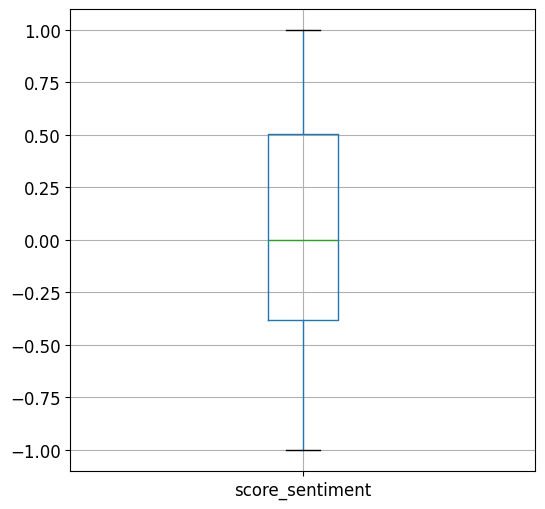

In [27]:
df_clean.boxplot(column=['score_sentiment'], fontsize='large', figsize=(6,6))

<Axes: >

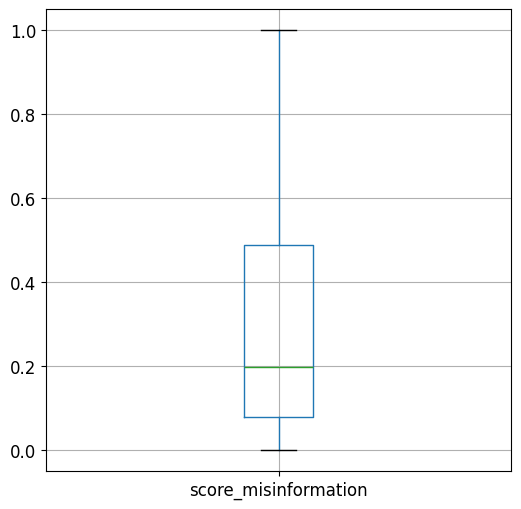

In [28]:
df_clean.boxplot(column=['score_misinformation'], fontsize='large', figsize=(6,6))

### 5. QQ-Plot

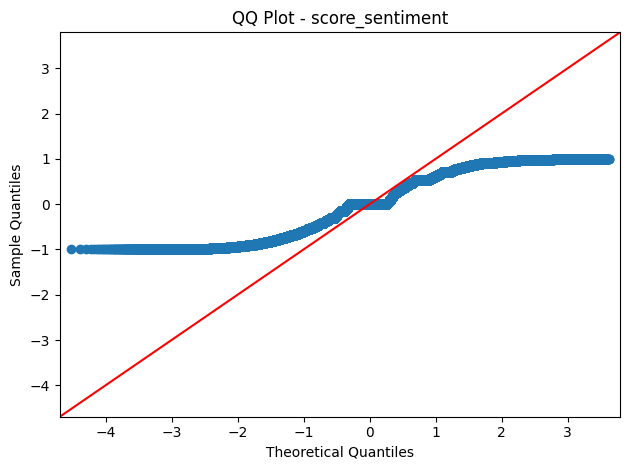

In [29]:
sm.qqplot(df_clean['score_sentiment'], line='45')
plt.title('QQ Plot - score_sentiment')
plt.tight_layout()
plt.show()

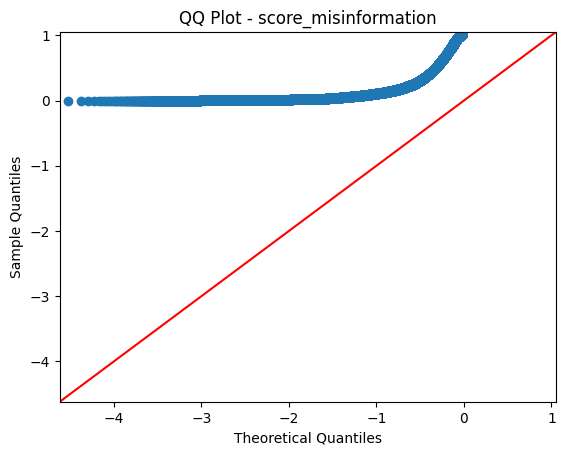

In [30]:
sm.qqplot(df_clean['score_misinformation'], line='45')
plt.title('QQ Plot - score_misinformation')
plt.show()

### 6. Teste de Normalidade

#### Score Sentiment

In [37]:
shapiro_ss = stats.shapiro(df_clean['score_sentiment'].dropna())

print(f"Shapiro-Wilk Statistic: {shapiro_ss.statistic}")
print(f"p-value: {shapiro_ss.pvalue}")

print(f'Is Normal: {shapiro_ss.pvalue >= 0.05}')

Shapiro-Wilk Statistic: 0.9623856812853971
p-value: 8.897899686071102e-109
Is Normal: False


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 337998.


In [38]:
lilliefors_ss = statsmodels.stats.diagnostic.lilliefors(df_clean['score_sentiment'].dropna(), dist='norm', pvalmethod='table')

print(f"Statistic: {lilliefors_ss[0]}")
print(f"p-value: {lilliefors_ss[1]}")

print(f'Is Normal: {lilliefors_ss[1] >= 0.05}')

Statistic: 0.12152561509216186
p-value: 0.0009999999999998899
Is Normal: False


In [40]:
jarque_bera_ss = stats.jarque_bera(df_clean['score_sentiment'].dropna())

print(f"Statistic: {jarque_bera_ss.statistic}")
print(f"p-value: {jarque_bera_ss.pvalue}")

print(f'Is Normal: {jarque_bera_ss.pvalue >= 0.05}')

Statistic: 12054.398174723185
p-value: 0.0
Is Normal: False


In [41]:
normaltest_ss = stats.normaltest(df_clean['score_sentiment'].dropna())

print(f"Statistic: {normaltest_ss.statistic}")
print(f"p-value: {normaltest_ss.pvalue}")

print(f'Is Normal: {normaltest_ss.pvalue >= 0.05}')

Statistic: 51573.95893688736
p-value: 0.0
Is Normal: False


#### Score Misinformation

In [42]:
shapiro_sm = stats.shapiro(df_clean['score_misinformation'].dropna())

print(f"Shapiro-Wilk Statistic: {shapiro_ss.statistic}")
print(f"p-value: {shapiro_ss.pvalue}")

print(f'Is Normal: {shapiro_ss.pvalue >= 0.05}')

Shapiro-Wilk Statistic: 0.9623856812853971
p-value: 8.897899686071102e-109
Is Normal: False


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 166402.


In [43]:
lilliefors_sm = statsmodels.stats.diagnostic.lilliefors(df_clean['score_misinformation'].dropna(), dist='norm', pvalmethod='table')

print(f"Statistic: {lilliefors_ss[0]}")
print(f"p-value: {lilliefors_ss[1]}")

print(f'Is Normal: {lilliefors_ss[1] >= 0.05}')

Statistic: 0.12152561509216186
p-value: 0.0009999999999998899
Is Normal: False


In [44]:
jarque_bera_sm = stats.jarque_bera(df_clean['score_misinformation'].dropna())

print(f"Statistic: {jarque_bera_ss.statistic}")
print(f"p-value: {jarque_bera_ss.pvalue}")

print(f'Is Normal: {jarque_bera_ss.pvalue >= 0.05}')

Statistic: 12054.398174723185
p-value: 0.0
Is Normal: False


In [45]:
normaltest_sm = stats.normaltest(df_clean['score_misinformation'].dropna())

print(f"Statistic: {normaltest_ss.statistic}")
print(f"p-value: {normaltest_ss.pvalue}")

print(f'Is Normal: {normaltest_ss.pvalue >= 0.05}')

Statistic: 51573.95893688736
p-value: 0.0
Is Normal: False


### 7. Best Fit Distribution (usando diferentes métodos)

In [47]:
dist_names = [
    'beta',
    'expon',
    'gamma',
    'lognorm',
    'norm',
    'pearson3',
    't',
    'triang',
    'uniform',
    'weibull_min',
    'weibull_max'
]

In [48]:
def check_distribution(dist_names, y_std, column_name):

    p_values = []
    distance = []
    D_less_p = []

    for distribution in dist_names:
        # Set up distribution and get fitted distribution parameters
        dist = getattr(scipy.stats, distribution)
        param = dist.fit(y_std)

        if distribution != "norm":
            D, p = scipy.stats.kstest(y_std, distribution, args=param)
        else:
            D, p = scipy.stats.kstest(y_std, distribution,  alternative='greater')

        #p = np.around(p, 5)
        p_values.append(p)

        #D = np.around(D, 5)
        distance.append(D)

        if D<p:
            D_less_p.append("yes")
        else:
            D_less_p.append("no")

    results = pd.DataFrame()
    results['Distribution'] = dist_names
    results['Distance'] = distance
    results['p_value'] = p_values
    results['D<p'] = D_less_p

    results.sort_values(['p_value'], ascending=False, inplace=True)


    print (f'\n${column_name} - Distributions sorted by goodness of fit:')
    print ('----------------------------------------')
    print (results)

#### Score Sentiment

In [55]:
scores_ss = df_clean['score_sentiment']
scores_clean_ss = scores_ss.dropna()
z_scores_ss = stats.zscore(scores_clean_ss)

In [56]:
check_distribution(dist_names, z_scores_ss, 'score_sentiment')

/usr/local/lib/python3.11/dist-packages/scipy/stats/_continuous_distns.py:6912: RuntimeWarning: invalid value encountered in log



$score_sentiment - Distributions sorted by goodness of fit:
----------------------------------------
   Distribution  Distance  p_value D<p
0          beta  0.118371      0.0  no
1         expon  0.247807      0.0  no
2         gamma  0.118801      0.0  no
3       lognorm  0.119172      0.0  no
4          norm  0.121526      0.0  no
5      pearson3  0.131865      0.0  no
6             t  0.121526      0.0  no
7        triang  0.118145      0.0  no
8       uniform  0.124071      0.0  no
9   weibull_min  0.114634      0.0  no
10  weibull_max  0.143595      0.0  no


<ipython-input-64-d565f9e86bab>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



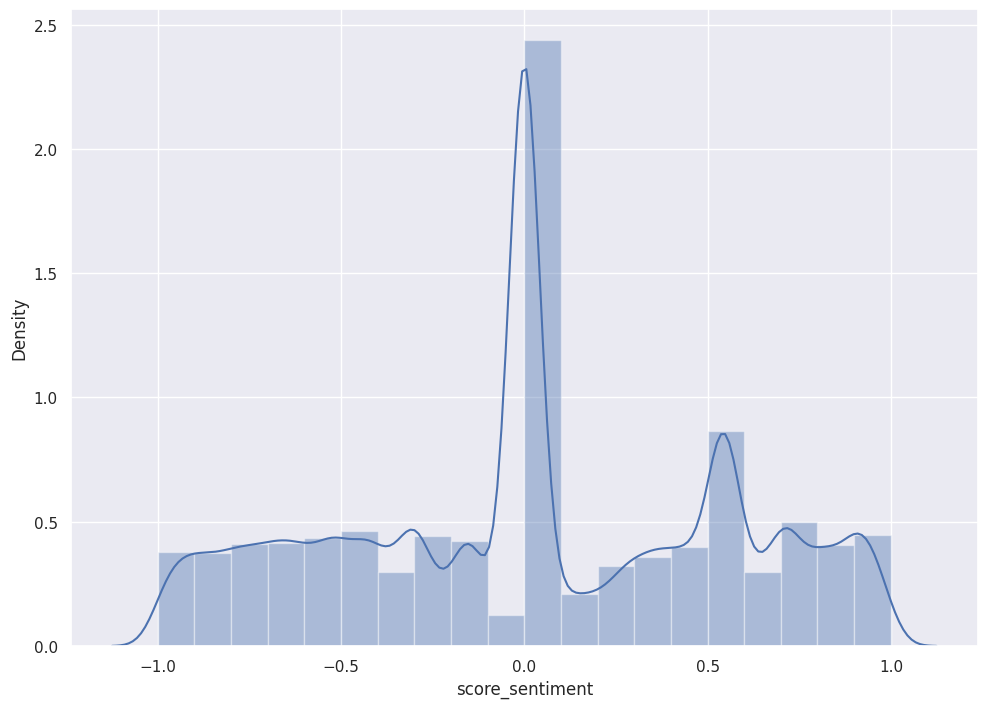

In [64]:
sns.distplot(scores_clean_ss, bins=k_ss)
plt.show()

#### Score Misinformation

In [57]:
scores_sm = df_clean['score_misinformation']
scores_clean_sm = scores_sm.dropna()
z_scores_sm = stats.zscore(scores_clean_sm)

In [58]:
check_distribution(dist_names, z_scores_sm, 'score_misinformation')

/usr/local/lib/python3.11/dist-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.11/dist-packages/scipy/stats/_continuous_distns.py:6912: RuntimeWarning: invalid value encountered in log



$score_misinformation - Distributions sorted by goodness of fit:
----------------------------------------
   Distribution  Distance        p_value D<p
5      pearson3  0.046544  1.043994e-313  no
2         gamma  0.046708  6.456362e-316  no
0          beta  0.107844   0.000000e+00  no
1         expon  0.048517   0.000000e+00  no
3       lognorm  0.068144   0.000000e+00  no
4          norm  0.155665   0.000000e+00  no
6             t  0.155665   0.000000e+00  no
7        triang  0.176090   0.000000e+00  no
8       uniform  0.322736   0.000000e+00  no
9   weibull_min  0.047291   0.000000e+00  no
10  weibull_max  0.114616   0.000000e+00  no


<ipython-input-65-172a8ffaefcb>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



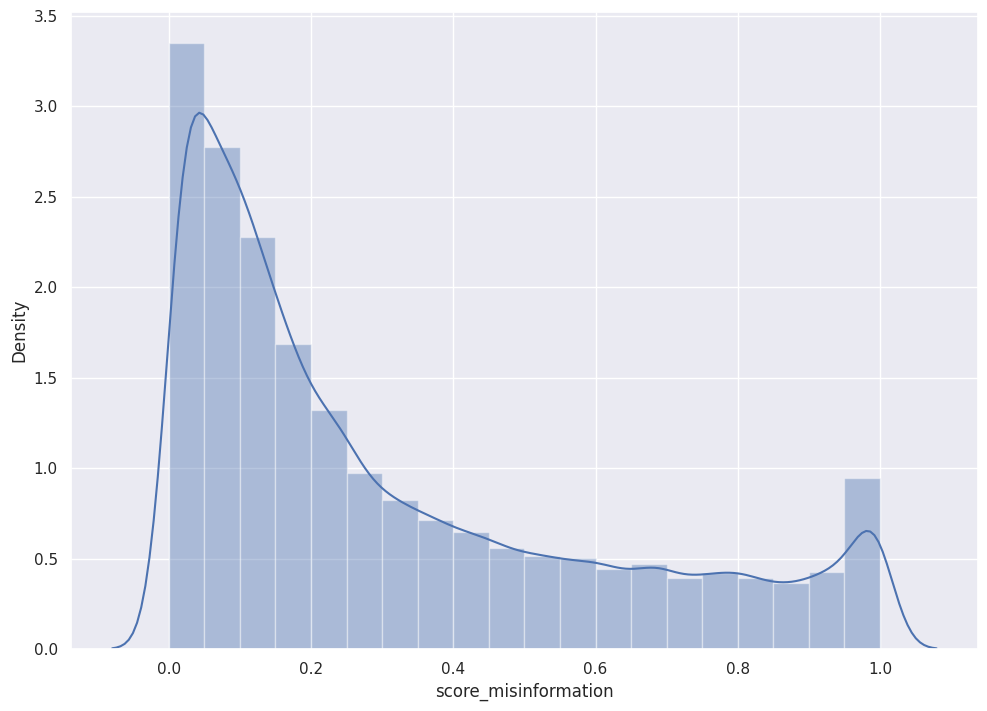

In [65]:
sns.distplot(scores_clean_sm, bins=k_sm)
plt.show()

## f) Para cada par de atributos númericos apresente

### 1. O Coeficiente de Correlação apropriado

Como nenhum dado segue a distribuição normal, utilizaremos a Correlação de Spearman

In [72]:
valid_data = df_clean[['score_sentiment', 'score_misinformation']].dropna()

x = valid_data['score_sentiment']
y = valid_data['score_misinformation']

correlation, p_value = stats.spearmanr(x, y)

print(f"Coeficiente de Spearman: {correlation}")
print(f"Valor-p: {p_value}")

Coeficiente de Spearman: -0.38877844225991115
Valor-p: 0.0


### 2. Um Gráfico de Dispersão

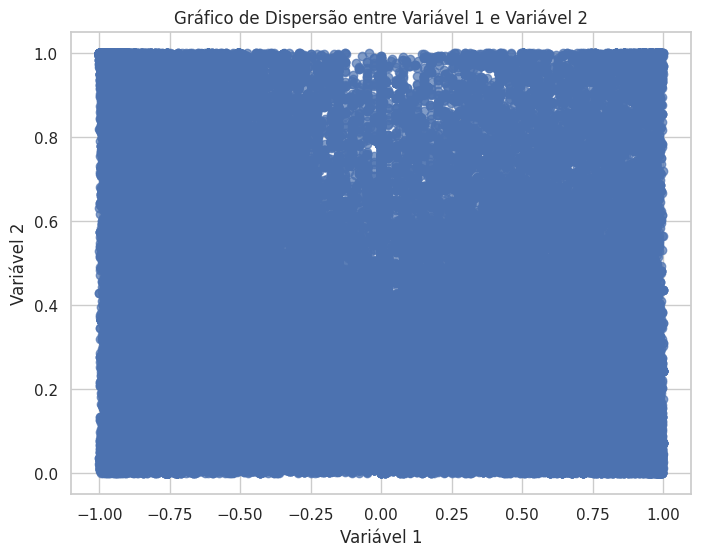

In [75]:
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.7)
plt.title('Gráfico de Dispersão entre Variável 1 e Variável 2')
plt.xlabel('Variável 1')
plt.ylabel('Variável 2')
plt.grid(True)
plt.show()

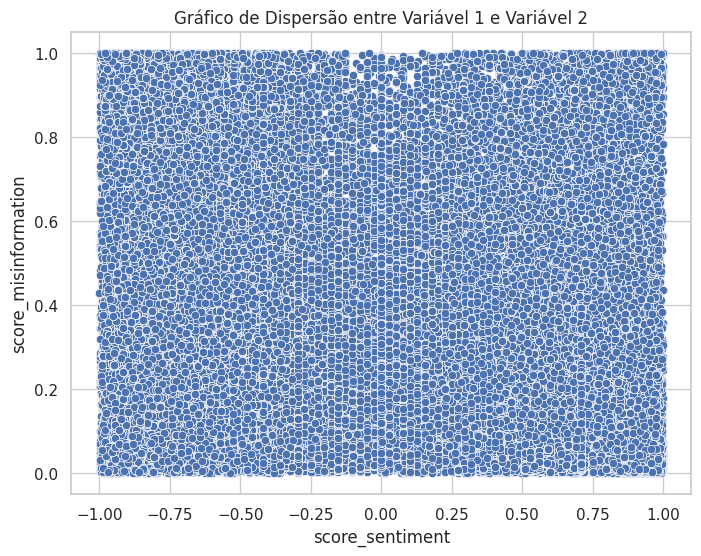

In [74]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.scatterplot(x='score_sentiment', y='score_misinformation', data=valid_data)
plt.title('Gráfico de Dispersão entre Variável 1 e Variável 2')
plt.show()

## g) Para cada par de atributos categóricos apresente

### 1. O resultado do método V de Cramer

## h) Crie uma visualização (gráfico) para apresentar

### 1. As quantidades de grupos, usuários e mensagens

### 2. A quantidade de mensagens que ponssuem apenas texto X mídia

### 3. Quantidade de mensagens por tipo de mídia (jpg, mp4 etc)

### 4. Relação entre a quantidade de mensagens e a quantidade de palavras presente nas mensagens

### 5. Quantidade de mensagens por estado

### 6. Quantidade de usuários por estado

### 7. Relação quantidade de usuários por quantidade de mensagens por estado

### 8. Quantidade de mensagens por país

### 9. Quantidade de mensagens Brasil X Países Estrangeiros

Não há informações sobre estado